In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import matplotlib.dates as mdates
from windrose import WindroseAxes
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn import datasets, linear_model
from tabulate import tabulate
import os

In [18]:
current_path = os.getcwd()
print(current_path)

d:\Work\04Script\01Oceanography\05ApiERA5


In [19]:
def convert_csv(dataset, **kwargs):
    """
  Get CSV data from a dataset.
  Args:
    dataset: Set Path to Dataset File (.nc)
    **kwargs: Keyword arguments.
    **Keyword argument:**
    * `coor`: A list of two numbers specifying the [Longitude, Latitude] of the point to get the data for. 
    The coordinates should be in decimal degrees.

  
  Returns:
    A Dataframe CSV.
  """
    ###Import data From Netcdf 
    data = Dataset(rf'{dataset}.nc')
    lon = data.variables["longitude"][:].filled(np.nan)
    lat = data.variables["latitude"][:].filled(np.nan)
    v10 = data.variables["v10"][:].filled(np.nan)
    u10 = data.variables ["u10"][:].filled(np.nan)

    time = data.variables["time"][:].filled(np.nan)
    time_unit = data.variables["time"].getncattr('units')
    time_cal = data.variables["time"].getncattr('calendar')
    local_time = num2date(time, units=time_unit,calendar= time_cal)

    wnd_speed= np.sqrt(u10**2+v10**2)
    wnd_dir = np.mod(270-np.rad2deg(np.arctan2(v10, u10)),360)
    ext_lon = kwargs["coor"][0]
    ext_lat = kwargs["coor"][1]

    sq_dif_lon = (lon-ext_lon)**2
    sq_dif_lat = (lat-ext_lat)**2
    index_lon = sq_dif_lon.argmin()
    index_lat = sq_dif_lat.argmin()
    print(lon[index_lon], lat[index_lat])

    time_str = []
    for x in local_time:
      time_str.append(str(x))
    time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

    d = {'time': time_list, 'wnd_speed(m/s)': wnd_speed[:,index_lat, index_lon], 'direction_(deg)': wnd_dir[:,index_lat, index_lon], 'u10': u10[:,index_lat, index_lon], 'v10': v10[:,index_lat, index_lon]}
    df = pd.DataFrame(data = d, index = None)
    df.to_csv(f'Hasil/{dataset}.csv')
    return df


In [73]:
def draw_graph(dataset, coor = [104.3, 0.9], time = False, title = 'Arus Laut'):
    df = convert_csv(dataset, coor = coor)

    if time == False:
        timestep = slice(None)
    else:
        start = time[0] - df['time'].iloc[0]
        start_time = int(start.total_seconds()/3600)
        end = time[1] - df['time'].iloc[0]
        end_time = int(end.total_seconds()/3600)
        timestep = slice(start_time,end_time)
    
    fig, ax1 = plt.subplots(1,2, figsize=(22,6), gridspec_kw={'width_ratios': [2, 1]})
    color = 'tab:blue'
    ax1[0].set_xlabel('Date')
    ax1[0].set_ylabel('Wind_Speed (m/s)', color = color)
    ax1[0].plot(df['time'].iloc[timestep], df['wnd_speed(m/s)'].iloc[timestep], color = color)
    ax1[0].tick_params(axis='y', labelcolor = color)
    ax1[0].set_title(title)

    ax2 = ax1[0].twinx()
    color = 'tab:red'
    ax2.set_ylabel("Wind_Direction (Deg)", color = color)
    ax2.plot(df['time'].iloc[timestep], df['direction_(deg)'].iloc[timestep], color = color)
    ax2.tick_params(axis='y', labelcolor = color)

    max_u = max(abs(df['u10']))
    max_v = max(abs(df['v10']))

    ax1[1].set_xlabel('U10 (m/s)')
    ax1[1].set_ylabel('V10 (m/s)')
    sc = ax1[1].scatter((df['u10'].iloc[timestep]*-1), (df['v10'].iloc[timestep]*-1), c = df['wnd_speed(m/s)'].iloc[timestep], cmap = 'plasma', s = 3)
    ax1[1].axvline(0, c='black', ls='--')
    ax1[1].axhline(0, c='black', ls='--')
    ax1[1].set_xlim(-1*max_u, max_u)
    ax1[1].set_ylim(-1*max_v, max_v)
    fig.colorbar(sc, label = 'Wind_speed (m/s)')

    wr = WindroseAxes.from_ax()
    wr.bar(df['direction_(deg)'].iloc[timestep], df['wnd_speed(m/s)'].iloc[timestep], edgecolor = 'white', normed = True, cmap = cm.cool)
    wr.set_legend()
    
    plt.show()

In [61]:
convert_csv('Data Angin 2022', coor = [104.3, 0.8])

104.25 0.8


,time,wnd_speed(m/s),direction_(deg),u10,v10
0,2021-01-01 00:00:00,9.803798,21.419429,-3.580273,-9.126669
1,2021-01-01 01:00:00,10.424776,21.825877,-3.875798,-9.677507
2,2021-01-01 02:00:00,9.706590,16.943577,-2.828790,-9.285249
3,2021-01-01 03:00:00,9.338032,14.452098,-2.330497,-9.042545
4,2021-01-01 04:00:00,9.217301,11.551084,-1.845687,-9.030619
...,...,...,...,...,...
17515,2022-12-31 19:00:00,8.865924,3.785851,-0.585395,-8.846577
17516,2022-12-31 20:00:00,8.936947,5.090815,-0.793017,-8.901693
17517,2022-12-31 21:00:00,8.916905,6.999715,-1.086653,-8.850445
17518,2022-12-31 22:00:00,7.467029,13.749718,-1.774772,-7.253048


104.25 0.8


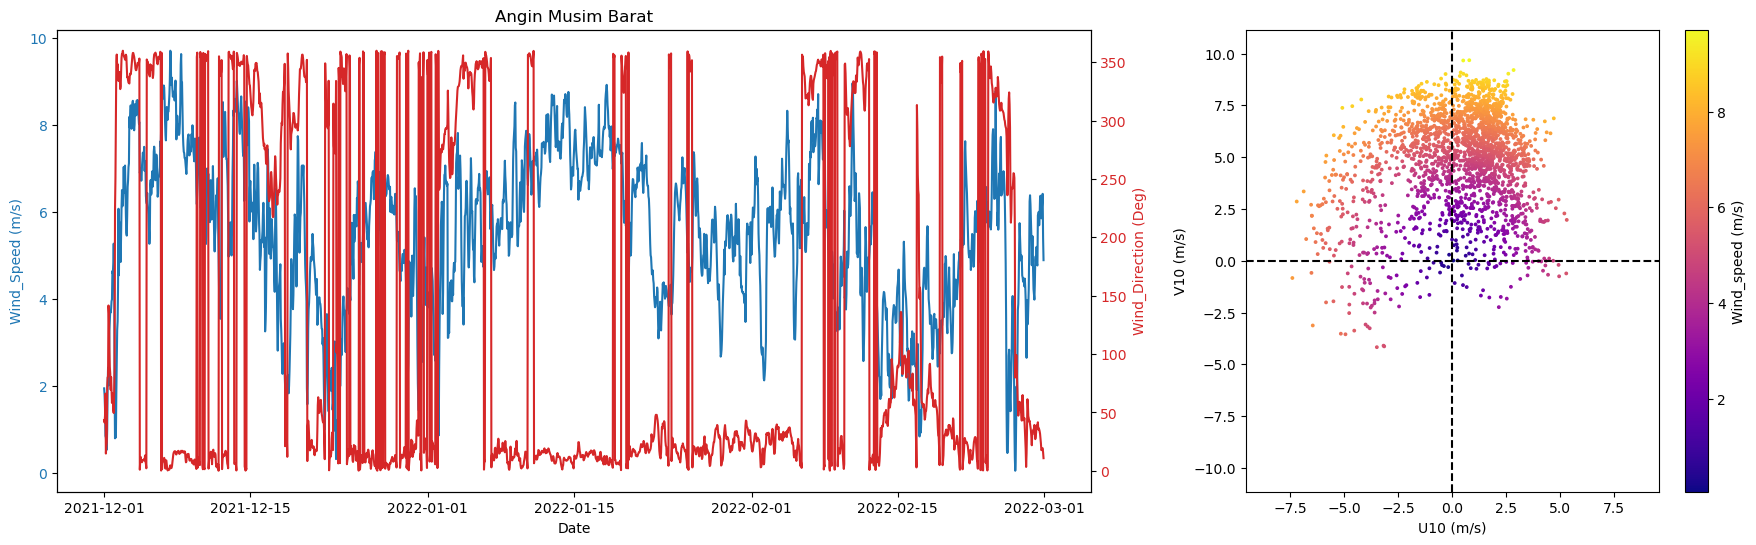

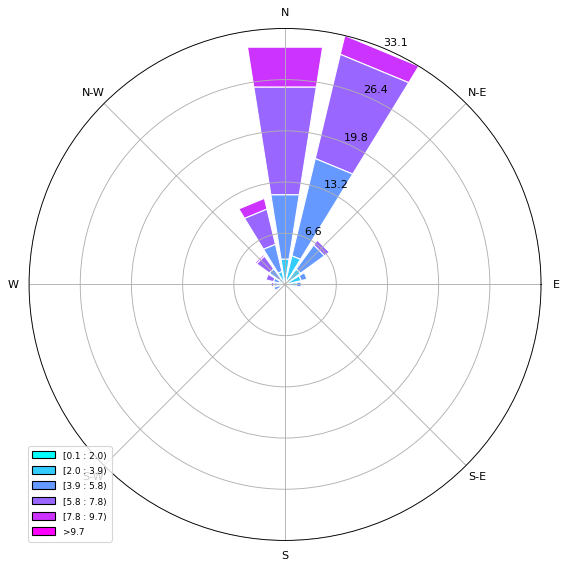

In [75]:
start_time = datetime(2021,12,1,00,00,00)
end_time = datetime(2022,3,1,00,00,00)

barat = draw_graph('Data Angin 2022', coor = [104.3, 0.8], time = [start_time, end_time], title = "Angin Musim Barat")